In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import fashion_mnist
import keras.backend as K
from keras.layers import Input, Flatten, Dense, Reshape, Lambda, Dropout, BatchNormalization

In [15]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255
y_train = y_train / 255

4422102/4422102 [==============================] - 0s 0us/step


In [16]:
x_train.shape

(60000, 28, 28)

In [17]:
hidden_dim = 10
batch_size = 32

In [18]:
input_img = Input((28, 28))
x = Flatten()(input_img)
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

In [19]:
loss_z_mean, loss_z_log_var = [(), ()]
def foo(args):
  global loss_z_mean, loss_z_log_var
  loss_z_mean, loss_z_log_var = args

  z_mean, z_log_var = args
  N = K.random_normal(shape = (batch_size, hidden_dim))
  delta = K.exp(z_log_var / 2) * N
  return z_mean + delta

In [20]:
h = Lambda(foo, output_shape = (hidden_dim,))([z_mean, z_log_var])

In [21]:
input_dec = Input(shape = (hidden_dim, ))
d = Dense(128, activation = 'relu')(input_dec)
d = Dense(256, activation = 'relu')(d)
d = Dense(28*28, activation = 'sigmoid')(d)
decoded = Reshape((28, 28))(d)

In [22]:
def loss(y, z):
  y = K.reshape(y, shape = (batch_size, 28*28))
  z = K.reshape(z, shape = (batch_size, 28*28))
  mse = K.sum(K.square(y - z), axis = 1)
  kl = -.5 * K.sum(1 + loss_z_log_var - K.square(loss_z_mean) - K.exp(loss_z_log_var), axis = 1)

  return mse# + kl

In [23]:
encoder = keras.Model(input_img, h, name = 'encoder')
decoder = keras.Model(input_dec, decoded, name = 'decoder')
vae = keras.Model(input_img, decoder(encoder(input_img)), name = 'vae')

In [24]:
vae.compile(optimizer = 'adam', loss = loss)

In [25]:
vae.fit(x_train, x_train, epochs = 5, batch_size = batch_size, shuffle = True)

Epoch 1/5
1875/1875 [==============================] - 24s 12ms/step - loss: 18.1302
Epoch 2/5
1875/1875 [==============================] - 21s 11ms/step - loss: 12.2267
Epoch 3/5
1875/1875 [==============================] - 21s 11ms/step - loss: 11.2004
Epoch 4/5
1875/1875 [==============================] - 21s 11ms/step - loss: 10.6651
Epoch 5/5
1875/1875 [==============================] - 22s 12ms/step - loss: 10.3514


1/1 [==============================] - 0s 62ms/step


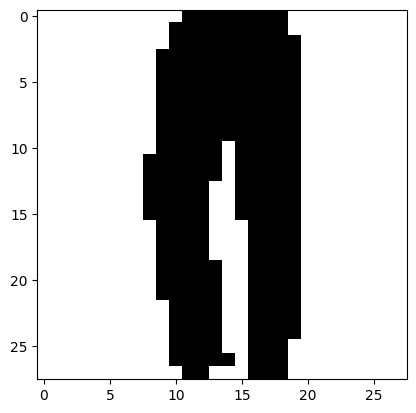

In [29]:
plt.imshow(vae.predict([x_test[2].reshape(-1, 28, 28, 1)])[0], cmap = 'gray_r')